# Die Zeit API

DIE ZEIT is one of the most famous german newspapers. It provides an API that allows users to retrieve data from articles contained in their archiv. In this project, we'll access this data and clean it,so that it's ready for some initial analysis. 

# Project's Goal

1) Get data from the API from the ZEIT newspaper

2) Complement the data via Webscrapping

3) Prepare the data for initial analysis. 

### Importing Libraries

In [1]:
import json
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re

### Reading Authorization

To access the API, a key is necessary. The key can be required by sending an email to the responsible team of the ZEIT newspaper. For more information, read: http://developer.zeit.de/quickstart/

In [2]:
authorization = open(r"C:\Users\celio\My Projects\Guided Projects\Bewerbung\auth.txt")
api_key = authorization.read()
headers = {"X-Authorization":api_key}

### Function to make requests to the API and read content

In [3]:
def request_and_read(url,limit):
    # url is a valid url
    # limit is the number of results from the 
    
    # turns url into string (if it's not in string type already)
    url = str(url)
    endpoint = r"{url}".format(url=url)
    
    # Fetches content
    r = requests.get(endpoint,
                    headers = headers, # headers is the parameter from the get method to pass the API key
                    params = {"limit":limit}) 
    # Read content
    content = json.loads(r.content)
    return content # Output is dictionary

# Exploring the API

The API has a very straight forward documentation [http://developer.zeit.de/quickstart/], in which all its endpoints are indicated. One great place to start is the products endpoint, that refers to the different formats produced by the ZEIT commercial group. 

In [4]:
erste_anfrage = request_and_read("http://api.zeit.de/product",10)

In [5]:
for d in erste_anfrage["matches"]:
    print("Product = {value}\nURL {href}\nURI {uri}\n".format(value = d["value"], href = d["href"], uri=d["uri"]))
    
print("Total = {}".format(erste_anfrage["found"]))

Product = ZEIT ONLINE
URL 
URI http://api.zeit.de/product/zede

Product = DIE ZEIT
URL 
URI http://api.zeit.de/product/zei

Product = Leserartikel
URL http://www.zeit.de/leserartikel/index
URI http://api.zeit.de/product/leserartikel

Product = ZEITmagazin
URL http://www.zeit.de/zeit-magazin/index
URI http://api.zeit.de/product/zmlb

Product = Test/Development
URL 
URI http://api.zeit.de/product/test

Product = ZEIT Campus
URL http://www.zeit.de/campus/index
URI http://api.zeit.de/product/ztcs

Product = ZEIT CAMPUS Ratgeber
URL http://www.zeit.de/campus/index
URI http://api.zeit.de/product/csrg

Product = ZEIT Wissen
URL http://www.zeit.de/wissen/zeit-wissen/index
URI http://api.zeit.de/product/ztwi

Product = ZEIT Geschichte
URL http://www.zeit.de/wissen/zeit-geschichte/index
URI http://api.zeit.de/product/ztgs

Product = Zeit Schweiz
URL 
URI http://api.zeit.de/product/zech

Total = 50


To avoid a tedious output, We've limited number of results to the first ten, but the API offers access to 50 different products of the ZEIT company (which inclues the newspaper and some more specialized productions towards history or science, like ZEITGeschichte and ZeitWissen, among others).

Not all endpoints are completely available though.

### ZeitMagazin

In [6]:
magazin = request_and_read("http://api.zeit.de/product/zmlb",10)
magazin

{'matches': [],
 'uri': 'http://api.zeit.de/product/zmlb',
 'value': 'ZEITmagazin',
 'href': 'http://www.zeit.de/zeit-magazin/index',
 'limit': 10,
 'offset': 0,
 'found': 0,
 'id': 'zmlb'}

## Zeit ONLINE

In [7]:
zeit = request_and_read("http://api.zeit.de/product/zei",1)
zeit # Contains data from article

{'matches': [{'subtitle': 'Die Banane ist nach dem Apfel die Lieblingsfrucht der Deutschen. Zeit für einen Blick über den Obsttellerrand hinaus.',
   'uuid': '5D5Up6ET9l7Wp8vMYt8Hkn',
   'title': 'Mehr als Obst',
   'href': 'http://www.zeit.de/2020/19/banane-anbau-wachstum-form-schaedlinge',
   'release_date': '2020-04-30T11:42:51Z',
   'uri': 'http://api.zeit.de/content/5D5Up6ET9l7Wp8vMYt8Hkn',
   'supertitle': 'Banane',
   'teaser_text': 'Die Banane ist nach dem Apfel die Lieblingsfrucht der Deutschen. Zeit für einen Blick über den Obsttellerrand hinaus.',
   'teaser_title': 'Mehr als Obst'}],
 'uri': 'http://api.zeit.de/product/zei',
 'value': 'DIE ZEIT',
 'href': '',
 'limit': 1,
 'offset': 0,
 'found': 125424,
 'id': 'zei'}

Judging by the difference in the output between ZeitMagazin and Zeit ONLINE, we can see that later yields results, while the first one does not. A probable resason for this is that some of the products, like Zeit Magazin, ZeitWissen und ZeitGeschichte are only available for subscribers. For this reason, they can't be made available through the API.

With this in mind, we can now find out which are the valid endpoints.

## Valid Endpoints

In [8]:
zweite_anfrage = request_and_read("http://api.zeit.de/product",50) # New request to retrieve all results

endpoints = [] # endpoints are added to this list

for d in zweite_anfrage["matches"]: # loops through the items in the requests's result
    endpoints.append(d["uri"]) # append results to the endpoints list
    

# 
gueltige_endpoints = []
ungueltige_endpoints = []

for uri in endpoints:  # if product is valid endpoint, 
                        # Prints a summary of the product, the number of results and the uri
        
    ergebnis =request_and_read(uri,1)
    if ergebnis["found"]== 0:
        ungueltige_endpoints.append(ergebnis["value"])
    elif ergebnis["found"]!= 0 or "0":
        print("\n",ergebnis["value"],ergebnis["found"], uri)
        gueltige_endpoints.append(ergebnis)


 ZEIT ONLINE 140567 http://api.zeit.de/product/zede

 DIE ZEIT 125424 http://api.zeit.de/product/zei

 DIE ZEIT 228443 http://api.zeit.de/product/zear


From all the endpoints above, it's clear the only three offer public access to the API. We can investigate them further.

In [9]:
products = [x["value"] for x in gueltige_endpoints] # List Comprehension, to create a column with the product's name
found = [x["found"] for x in gueltige_endpoints] # List Comprehension, to create a column with the number of articles

points = pd.DataFrame({"Endpoints":products,"N_Artikel":found}) # Instatiates a DataFrame

print("Gesamt Anzahl der Artikel = {}".format(points["N_Artikel"].sum()))

points["Anteil"] = points["N_Artikel"]/points["N_Artikel"].sum()
points

Gesamt Anzahl der Artikel = 494434


,Endpoints,N_Artikel,Anteil
0,ZEIT ONLINE,140567,0.284299
1,DIE ZEIT,125424,0.253672
2,DIE ZEIT,228443,0.462029


### ZEIT ONLINE

It's the newspaper's website. 

### DIE ZEIT (first endpoint)

As far as my knowledge goes, those are articles meant for the printed newspaper of the company. Some of them are then transformed in digital format and uploaded to the website. 

### DIE ZEIT (second endpoint)

Those articles belong to an older archiv of the Zeit newspaper. It's a miscellaneous of news from many decades ago up until 2018.

# Retrieving Articles

Now that we have a brighter idea who the API works, we can start to retrieve information on the articles. However, to avoid giving this data wrangling and cleaning project a disproportionate length, we'll focus on the ZEIT ONLINE endpoint.

## The ZEIT ONLINE Endpoint

We'll retrieve information from a thousand (1000) articles.

However, before we do this, the read_and_request function we created above has to me modified, so that it can take the offset parameters. This will allow us to get not the first 100 results, but a thousando results after the determined offset (for example, if offset is 100, we'll get the results from 101 to 1101 - and not from 0 to 1000). 

This is specially important, because we'll complement the information with the number of commentaries each article has had and younger, recently published articles haven't had the time to reach "maximum number of comments". 

### Adjusting the Function

In [10]:
def request_and_read(url,limit,offset):
    # url is a valid url
    # limit is the number of results from the 
    
    # turns url into string (if it's not in string type already)
    url = str(url)
    endpoint = r"{url}".format(url=url)
    
    # Fetches content
    r = requests.get(endpoint,
                    headers = headers, # headers is the parameter from the get method to pass the API key
                    params = {"limit":limit,
                             "offset":offset}) 
    # Read content
    content = json.loads(r.content)
    return content # Output is dictionary

In [11]:
 # request to the zeit online endpoint
zeit_online_anfrage = request_and_read("http://api.zeit.de/product/zede",1000,500)

### Extract Article Data

We can write another function to extract data from the keys contained in the content dictionary

In [12]:
def get_metadata(big_dictionary): # Die Funktion nimmt die Dictionary aus der request_and_read Funktion an
    
    list_of_dictionaries = big_dictionary["matches"] # Sie greift auf die Schlüssel "matches" in Dictionary zu
    
    # Instaziierung einer Dictionary, um die gültigen Werte zu empfangen
    valid = {"subtitle": [], "uuid": [],"title": [],"href":[],
         "release_date":[],"uri":[],"supertitle": [],"teaser_text":[],"teaser_title":[]}
    
    for d in list_of_dictionaries: # Vergleicht die Keys von Endpoint(list of dictionaries) mit dem Keys von Valid
        
        if d.keys() == valid.keys(): # Wenn Keys übereinstimmen, setzt Auspackung der Daten fort
            valid["subtitle"].append(d["subtitle"])
            valid["uuid"].append(d["uuid"])
            valid["title"].append(d["title"])
            valid["href"].append(d["href"])
            valid["release_date"].append(d["release_date"])
            valid["uri"].append(d["uri"])
            valid["supertitle"].append(d["supertitle"])
            valid["teaser_text"].append(d["teaser_text"])
            valid["teaser_title"].append(d["teaser_title"])
            
        else: # Wenn Keys nicht übereinstimmen, überspringt diesen Eintrag
            continue
            
    # Dieser Ansatz ist wichtig, um die Sammlung von fehlenden oder defekten Daten zu vermeiden
    # Mit früheren Versionen diese Funktion hatte ich oft unerwartete Abstürze
    # bei dem Auftritt eines Eintrags, der von der Regel abweicht. 
            
    return  valid

In [13]:
zeit_online_dict = get_metadata(zeit_online_anfrage)

### Controling Results

We can check if everything went alright by doing the following:

In [14]:
for key in zeit_online_dict:
    print(len(zeit_online_dict[key]))

999
999
999
999
999
999
999
999
999


This means that from the 1000 articles we tried to retrieve, 999 yielded valid results.

A preview of the results looks like the output below.

In [15]:
for key in zeit_online_dict:
    print(key, " = ",zeit_online_dict[key][0],"\n")

subtitle  =  Die Notaufnahme ist das wichtigste Tor ins Krankenhaus – dort entscheidet sich, wie schnell ein Verdachtsfall erkannt und isoliert wird. Unterwegs mit einem Chefarzt 

uuid  =  tjGeyYcvvupRcjD5YaTzG 

title  =  Ein Netz, das Viren fangen kann 

href  =  http://www.zeit.de/hamburg/2020-04/notaufnahmen-aerzte-coronavirus-verdachtsfall-tests 

release_date  =  2020-04-22T13:54:56Z 

uri  =  http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG 

supertitle  =  Notaufnahmen 

teaser_text  =  Die Notaufnahme ist das wichtigste Tor ins Krankenhaus – dort entscheidet sich, wie schnell ein Verdachtsfall erkannt und isoliert wird. Unterwegs mit einem Chefarzt 

teaser_title  =  Ein Netz, das Viren fangen kann 



## Getting Extra Information

As mentioned, we wanted to complement the data with the number of comments each article has gotten. One of the keys contained in the zeit_online_dict is specially useful in this task, the "uri" key.

Until now, we've explored only the "products" endpoint of the Zeit API. Through the uri, however, we can access another one, the content endpoint. At this "location", we can get more information on the articles.

In [16]:
zeit_online_dict["uri"][:5]

['http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG',
 'http://api.zeit.de/content/660V6H9CAOTGTw0HD6GT1x',
 'http://api.zeit.de/content/7JnTgL9LnGtuIY8ESds5e0',
 'http://api.zeit.de/content/6X1Ngx5oYPZW4o1VuCyZoY',
 'http://api.zeit.de/content/2rEXFrxDqow80Jii4EO4y2']

In [17]:
daten = request_and_read(zeit_online_dict["uri"][0],10,0) # retrieves the first article
daten

{'teaser_title': 'Ein Netz, das Viren fangen kann',
 'uuid': 'tjGeyYcvvupRcjD5YaTzG',
 'title': 'Ein Netz, das Viren fangen kann',
 'release_date': '2020-04-22T13:54:56Z',
 'uri': 'http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG',
 'relations': [],
 'supertitle': 'Notaufnahmen',
 'href': 'http://www.zeit.de/hamburg/2020-04/notaufnahmen-aerzte-coronavirus-verdachtsfall-tests',
 'teaser_text': 'Die Notaufnahme ist das wichtigste Tor ins Krankenhaus – dort entscheidet sich, wie schnell ein Verdachtsfall erkannt und isoliert wird. Unterwegs mit einem Chefarzt',
 'keywords': [{'uri': 'http://api.zeit.de/keyword/krankenhaus',
   'rel': 'subject',
   'name': 'Krankenhaus'},
  {'uri': 'http://api.zeit.de/keyword/infektion',
   'rel': 'subject',
   'name': 'Infektion'},
  {'uri': 'http://api.zeit.de/keyword/pflegeheim',
   'rel': 'subject',
   'name': 'Pflegeheim'},
  {'uri': 'http://api.zeit.de/keyword/gesundheitssystem',
   'rel': 'subject',
   'name': 'Gesundheitssystem'},
  {'uri': 'http:/

In spite of the truncated view, at the content endpoint we can find other useful information, like keywords and authors

In [18]:
def get_daten(l):
    daten = {'teaser_title':[],'uuid':[],'title':[],
             'release_date':[],'uri':[],'relations':[], 
             'supertitle':[], 'href':[], 'teaser_text':[], 
             'keywords':[], 'creators':[], 'categories':[]} # dictionary that receives the data
    for uri in l:
        info = request_and_read(str(uri),10,0) # makes a request and reads the results
        
#         if info.keys()==daten.keys(): # Compares keys in daten and keys in output dictionary
                                        # This avoids troublesome data
            
            # Every key in the dictionary contains multiple values
            
            # If the keys in the daten dictionary match the keys in the output dictionary, adds data to daten
        daten["uri"].append(info["uri"])
    
        for word in info["keywords"]: # loops through the items in keywords
                                            
            
            daten["keywords"].append((str(uri),word["name"])) 
                
    
        for creator in info["creators"]: 
            daten["creators"].append((str(uri),creator["name"]))
        
    
        for c in info["categories"]: 
            daten["categories"].append((str(uri),c["name"]))
        
        
    return daten # Some keys will remain empty, since they've already been collected before
        

In [19]:
zeit_online_daten  = get_daten(zeit_online_dict["uri"])

## Controling The Results

In [20]:
for key in zeit_online_daten:
    print(key," ",len(zeit_online_daten[key]))

teaser_title   0
uuid   0
title   0
release_date   0
uri   999
relations   0
supertitle   0
href   0
teaser_text   0
keywords   3870
creators   1130
categories   1051


In [21]:
zeit_online_daten["uri"][:5]

['http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG',
 'http://api.zeit.de/content/660V6H9CAOTGTw0HD6GT1x',
 'http://api.zeit.de/content/7JnTgL9LnGtuIY8ESds5e0',
 'http://api.zeit.de/content/6X1Ngx5oYPZW4o1VuCyZoY',
 'http://api.zeit.de/content/2rEXFrxDqow80Jii4EO4y2']

Everything seems to be fine, so we'll proceed to retrieve the number of comments for every post.

## Finding the Number Of Comments

In the zeit_online_dict dictionary there is another helpful key, which can aid us to retrieve the number of comments, namely the "href" key. It contains the urls for the articles.

With WebScrapping, we can access the articles an retrieve the number of comments.

In [22]:
zeit_online_dict["href"][:5]

['http://www.zeit.de/hamburg/2020-04/notaufnahmen-aerzte-coronavirus-verdachtsfall-tests',
 'http://www.zeit.de/entdecken/2020-04/oktoberfest-bayern-volksfest-hommage',
 'http://www.zeit.de/wissen/gesundheit/2020-04/coronavirus-impfstoff-klinische-studie',
 'http://www.zeit.de/sport/2020-04/machtspieler-buch-auszug-syrien',
 'http://www.zeit.de/sport/2020-04/wm-prozess-verjaehrungsfrist-verlaengerung-dfb']

In [23]:
def new_find_comments(a_list):
    kommentare = {"href":[],
                 "Kommentare_Anzahl":[]}
    for url in a_list:
        
        try:
            html = requests.get(str(url))
            content = BeautifulSoup(html.content,"html.parser")
            comment = content.find(class_="comment-section__headline")
        
        # Some elements result in a list object, some objects in a string object
        # To avoid errors, the function accepts both outputs
        # however another step of data cleaning is necessary
        
        except:
            print("Ein Fehler ist bei folgender URI aufgetreten: {}".format(url))
            comment = "Nicht gefunden"
    
        kommentare["href"].append(url)
        kommentare["Kommentare_Anzahl"].append(comment)
    
    kommentare = pd.DataFrame(kommentare)                                           
    
    return kommentare # Output is a DataFrame

# This function can be optimized, among other things to clean the number of comments inside the function

In [24]:
kommentare_zeit_online = new_find_comments(zeit_online_dict["href"])

## Controling Results

In [25]:
kommentare_zeit_online.isnull().sum()

href                   0
Kommentare_Anzahl    103
dtype: int64

Again, everything seems to be alright, even though no comments were found for 103 articles.

# Data Cleaning

At the present moment, we have three objects containing data:

1) A dictionary called zeit_online_dict, with the results of the first data wrangling

2) The zeit_online_daten resulting from the second data gathering

3) A DataFrame containing the commentaries from every url in the zeit_online_dict

The first thing to do is to transform these objects into others that make it easier to manipulate data.

## Transforming Dictionaries in DataFrames

Notice that the way we collected the data helps a direct transformation

In [26]:
zeit_online_dict_df = pd.DataFrame(zeit_online_dict)
zeit_online_dict_df.head()

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title
0,Die Notaufnahme ist das wichtigste Tor ins Kra...,tjGeyYcvvupRcjD5YaTzG,"Ein Netz, das Viren fangen kann",http://www.zeit.de/hamburg/2020-04/notaufnahme...,2020-04-22T13:54:56Z,http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG,Notaufnahmen,Die Notaufnahme ist das wichtigste Tor ins Kra...,"Ein Netz, das Viren fangen kann"
1,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",660V6H9CAOTGTw0HD6GT1x,Warum ich die Wiesn trotzdem vermissen werde,http://www.zeit.de/entdecken/2020-04/oktoberfe...,2020-04-22T13:52:29Z,http://api.zeit.de/content/660V6H9CAOTGTw0HD6GT1x,Oktoberfest,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",Warum ich die Wiesn trotzdem vermissen werde
2,In Deutschland ist zum ersten Mal eine klinisc...,7JnTgL9LnGtuIY8ESds5e0,Erste klinische Studie zu Corona-Impfstoff zug...,http://www.zeit.de/wissen/gesundheit/2020-04/c...,2020-04-22T12:46:27Z,http://api.zeit.de/content/7JnTgL9LnGtuIY8ESds5e0,Coronavirus,In Deutschland ist zum ersten Mal eine klinisc...,Erste klinische Studie zu Corona-Impfstoff zug...
3,"Das Buch ""Machtspieler"" erzählt, wie Fußball b...",6X1Ngx5oYPZW4o1VuCyZoY,Fußball als Kriegswaffe,http://www.zeit.de/sport/2020-04/machtspieler-...,2020-04-22T12:16:04Z,http://api.zeit.de/content/6X1Ngx5oYPZW4o1VuCyZoY,"Buch ""Machtspieler""","Das Buch ""Machtspieler"" erzählt, wie Fußball b...",Fußball als Kriegswaffe
4,Der Prozess um die Betrugsvorwürfe um die Fußb...,2rEXFrxDqow80Jii4EO4y2,Prozess um Fußball-WM 2006 wird eingestellt,http://www.zeit.de/sport/2020-04/wm-prozess-ve...,2020-04-22T11:58:53Z,http://api.zeit.de/content/2rEXFrxDqow80Jii4EO4y2,WM-Prozess,Der Prozess um die Betrugsvorwürfe um die Fußb...,Prozess um Fußball-WM 2006 wird eingestellt


### Organizing the Data

The zeit_online_daten dictionary has keys with different lengths, for this reason, the conversion is not so straight forward. Therefore, we have to organize the data first. 

In [27]:
def organize(l):
    end_values = [] # Creates a list
    
    df = pd.DataFrame(l) 
    # Converts the list into a DataFrame
    # the resulting columns of the DataFrame after the conversion are 0 and 1
    
    for uri in df[0].unique(): # For loop through the unique uris
        group = df.loc[df[0]==uri,1] # Groups keywords according to uri and selects the 1 column
        wanted_values = group.values # Gets the values contained in the column related to each uri
        end_values.append([uri,wanted_values]) # Appends the uri and the values to the end values list
        
    end_values = pd.DataFrame(end_values) # Converts series into a DataFrame
    return end_values # Putput is a DataFrame


In [28]:
keywords = organize(zeit_online_daten["keywords"])
autors = organize(zeit_online_daten["creators"])
products = organize(zeit_online_daten["categories"])
keywords.head()

,0,1
0,http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG,"[Krankenhaus, Infektion, Pflegeheim, Gesundhei..."
1,http://api.zeit.de/content/660V6H9CAOTGTw0HD6GT1x,"[Ausnahmezustand, Oktoberfest, Bayern]"
2,http://api.zeit.de/content/7JnTgL9LnGtuIY8ESds5e0,"[Gesundheitssystem, Medizintechnik, Mainz, Rhe..."
3,http://api.zeit.de/content/6X1Ngx5oYPZW4o1VuCyZoY,"[Literatur, Syrien, Baschar al-Assad]"
4,http://api.zeit.de/content/2rEXFrxDqow80Jii4EO4y2,"[Theo Zwanziger, Wolfgang Niersbach, Franz Bec..."


### Chaging the Name of the Columns

In [29]:
keywords.columns = ["uri","keywords"]
autors.columns = ["uri","autors"]
products.columns = ["uri","product"]

In [30]:
keywords.head(2)

,uri,keywords
0,http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG,"[Krankenhaus, Infektion, Pflegeheim, Gesundhei..."
1,http://api.zeit.de/content/660V6H9CAOTGTw0HD6GT1x,"[Ausnahmezustand, Oktoberfest, Bayern]"


## Merging The DataFrames

Finally we can merge the DataFrames. To make the results clear, we can use the merge method, which works much like a SQL join.

**1) zeit_online_dict_df on keywords**

In [31]:
zeit_online_df = zeit_online_dict_df.merge(keywords,how="inner",on="uri")

In [32]:
zeit_online_df.head()

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title,keywords
0,Die Notaufnahme ist das wichtigste Tor ins Kra...,tjGeyYcvvupRcjD5YaTzG,"Ein Netz, das Viren fangen kann",http://www.zeit.de/hamburg/2020-04/notaufnahme...,2020-04-22T13:54:56Z,http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG,Notaufnahmen,Die Notaufnahme ist das wichtigste Tor ins Kra...,"Ein Netz, das Viren fangen kann","[Krankenhaus, Infektion, Pflegeheim, Gesundhei..."
1,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",660V6H9CAOTGTw0HD6GT1x,Warum ich die Wiesn trotzdem vermissen werde,http://www.zeit.de/entdecken/2020-04/oktoberfe...,2020-04-22T13:52:29Z,http://api.zeit.de/content/660V6H9CAOTGTw0HD6GT1x,Oktoberfest,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",Warum ich die Wiesn trotzdem vermissen werde,"[Ausnahmezustand, Oktoberfest, Bayern]"
2,In Deutschland ist zum ersten Mal eine klinisc...,7JnTgL9LnGtuIY8ESds5e0,Erste klinische Studie zu Corona-Impfstoff zug...,http://www.zeit.de/wissen/gesundheit/2020-04/c...,2020-04-22T12:46:27Z,http://api.zeit.de/content/7JnTgL9LnGtuIY8ESds5e0,Coronavirus,In Deutschland ist zum ersten Mal eine klinisc...,Erste klinische Studie zu Corona-Impfstoff zug...,"[Gesundheitssystem, Medizintechnik, Mainz, Rhe..."
3,"Das Buch ""Machtspieler"" erzählt, wie Fußball b...",6X1Ngx5oYPZW4o1VuCyZoY,Fußball als Kriegswaffe,http://www.zeit.de/sport/2020-04/machtspieler-...,2020-04-22T12:16:04Z,http://api.zeit.de/content/6X1Ngx5oYPZW4o1VuCyZoY,"Buch ""Machtspieler""","Das Buch ""Machtspieler"" erzählt, wie Fußball b...",Fußball als Kriegswaffe,"[Literatur, Syrien, Baschar al-Assad]"
4,Der Prozess um die Betrugsvorwürfe um die Fußb...,2rEXFrxDqow80Jii4EO4y2,Prozess um Fußball-WM 2006 wird eingestellt,http://www.zeit.de/sport/2020-04/wm-prozess-ve...,2020-04-22T11:58:53Z,http://api.zeit.de/content/2rEXFrxDqow80Jii4EO4y2,WM-Prozess,Der Prozess um die Betrugsvorwürfe um die Fußb...,Prozess um Fußball-WM 2006 wird eingestellt,"[Theo Zwanziger, Wolfgang Niersbach, Franz Bec..."


**2) zeit_online_df on autors**

In [33]:
zeit_online_df = zeit_online_df.merge(autors,how="inner",on="uri")
zeit_online_df.head(3)

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title,keywords,autors
0,Die Notaufnahme ist das wichtigste Tor ins Kra...,tjGeyYcvvupRcjD5YaTzG,"Ein Netz, das Viren fangen kann",http://www.zeit.de/hamburg/2020-04/notaufnahme...,2020-04-22T13:54:56Z,http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG,Notaufnahmen,Die Notaufnahme ist das wichtigste Tor ins Kra...,"Ein Netz, das Viren fangen kann","[Krankenhaus, Infektion, Pflegeheim, Gesundhei...",[Nike Heinen]
1,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",660V6H9CAOTGTw0HD6GT1x,Warum ich die Wiesn trotzdem vermissen werde,http://www.zeit.de/entdecken/2020-04/oktoberfe...,2020-04-22T13:52:29Z,http://api.zeit.de/content/660V6H9CAOTGTw0HD6GT1x,Oktoberfest,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",Warum ich die Wiesn trotzdem vermissen werde,"[Ausnahmezustand, Oktoberfest, Bayern]",[Elisabeth Kagermeier]
2,In Deutschland ist zum ersten Mal eine klinisc...,7JnTgL9LnGtuIY8ESds5e0,Erste klinische Studie zu Corona-Impfstoff zug...,http://www.zeit.de/wissen/gesundheit/2020-04/c...,2020-04-22T12:46:27Z,http://api.zeit.de/content/7JnTgL9LnGtuIY8ESds5e0,Coronavirus,In Deutschland ist zum ersten Mal eine klinisc...,Erste klinische Studie zu Corona-Impfstoff zug...,"[Gesundheitssystem, Medizintechnik, Mainz, Rhe...",[Sarah Lena Grahn]


**3) zeit_online_df on products**

In [34]:
zeit_online_df = zeit_online_df.merge(products,how="inner",on="uri")
zeit_online_df.head(3)

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title,keywords,autors,product
0,Die Notaufnahme ist das wichtigste Tor ins Kra...,tjGeyYcvvupRcjD5YaTzG,"Ein Netz, das Viren fangen kann",http://www.zeit.de/hamburg/2020-04/notaufnahme...,2020-04-22T13:54:56Z,http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG,Notaufnahmen,Die Notaufnahme ist das wichtigste Tor ins Kra...,"Ein Netz, das Viren fangen kann","[Krankenhaus, Infektion, Pflegeheim, Gesundhei...",[Nike Heinen],[ZEIT ONLINE]
1,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",660V6H9CAOTGTw0HD6GT1x,Warum ich die Wiesn trotzdem vermissen werde,http://www.zeit.de/entdecken/2020-04/oktoberfe...,2020-04-22T13:52:29Z,http://api.zeit.de/content/660V6H9CAOTGTw0HD6GT1x,Oktoberfest,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",Warum ich die Wiesn trotzdem vermissen werde,"[Ausnahmezustand, Oktoberfest, Bayern]",[Elisabeth Kagermeier],[ZEIT ONLINE]
2,In Deutschland ist zum ersten Mal eine klinisc...,7JnTgL9LnGtuIY8ESds5e0,Erste klinische Studie zu Corona-Impfstoff zug...,http://www.zeit.de/wissen/gesundheit/2020-04/c...,2020-04-22T12:46:27Z,http://api.zeit.de/content/7JnTgL9LnGtuIY8ESds5e0,Coronavirus,In Deutschland ist zum ersten Mal eine klinisc...,Erste klinische Studie zu Corona-Impfstoff zug...,"[Gesundheitssystem, Medizintechnik, Mainz, Rhe...",[Sarah Lena Grahn],[ZEIT ONLINE]


**4) zeit_online_df on zeit_online_kommentare**

So far, we've done the following:

a) Convert the zeit_online_dict into a DataFrame

b) Convert the keywords, creators and categories keys from the zeit_online_daten dictionary into DataFrames

c) Merged the DataFrames

Finally, it's time to add the number of commentaries to the DataFrame

In [35]:
zeit_online_df = zeit_online_df.merge(kommentare_zeit_online, how = "inner", on = "href")
zeit_online_df.head()

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title,keywords,autors,product,Kommentare_Anzahl
0,Die Notaufnahme ist das wichtigste Tor ins Kra...,tjGeyYcvvupRcjD5YaTzG,"Ein Netz, das Viren fangen kann",http://www.zeit.de/hamburg/2020-04/notaufnahme...,2020-04-22T13:54:56Z,http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG,Notaufnahmen,Die Notaufnahme ist das wichtigste Tor ins Kra...,"Ein Netz, das Viren fangen kann","[Krankenhaus, Infektion, Pflegeheim, Gesundhei...",[Nike Heinen],[ZEIT ONLINE],None
1,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",660V6H9CAOTGTw0HD6GT1x,Warum ich die Wiesn trotzdem vermissen werde,http://www.zeit.de/entdecken/2020-04/oktoberfe...,2020-04-22T13:52:29Z,http://api.zeit.de/content/660V6H9CAOTGTw0HD6GT1x,Oktoberfest,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",Warum ich die Wiesn trotzdem vermissen werde,"[Ausnahmezustand, Oktoberfest, Bayern]",[Elisabeth Kagermeier],[ZEIT ONLINE],[\n 129 Kommentare\n ...
2,In Deutschland ist zum ersten Mal eine klinisc...,7JnTgL9LnGtuIY8ESds5e0,Erste klinische Studie zu Corona-Impfstoff zug...,http://www.zeit.de/wissen/gesundheit/2020-04/c...,2020-04-22T12:46:27Z,http://api.zeit.de/content/7JnTgL9LnGtuIY8ESds5e0,Coronavirus,In Deutschland ist zum ersten Mal eine klinisc...,Erste klinische Studie zu Corona-Impfstoff zug...,"[Gesundheitssystem, Medizintechnik, Mainz, Rhe...",[Sarah Lena Grahn],[ZEIT ONLINE],[\n 28 Kommentare\n ...
3,"Das Buch ""Machtspieler"" erzählt, wie Fußball b...",6X1Ngx5oYPZW4o1VuCyZoY,Fußball als Kriegswaffe,http://www.zeit.de/sport/2020-04/machtspieler-...,2020-04-22T12:16:04Z,http://api.zeit.de/content/6X1Ngx5oYPZW4o1VuCyZoY,"Buch ""Machtspieler""","Das Buch ""Machtspieler"" erzählt, wie Fußball b...",Fußball als Kriegswaffe,"[Literatur, Syrien, Baschar al-Assad]",[Ronny Blaschke],[ZEIT ONLINE],[\n 4 Kommentare\n ...
4,Der Prozess um die Betrugsvorwürfe um die Fußb...,2rEXFrxDqow80Jii4EO4y2,Prozess um Fußball-WM 2006 wird eingestellt,http://www.zeit.de/sport/2020-04/wm-prozess-ve...,2020-04-22T11:58:53Z,http://api.zeit.de/content/2rEXFrxDqow80Jii4EO4y2,WM-Prozess,Der Prozess um die Betrugsvorwürfe um die Fußb...,Prozess um Fußball-WM 2006 wird eingestellt,"[Theo Zwanziger, Wolfgang Niersbach, Franz Bec...",[Anna-Lena Schlitt],[ZEIT ONLINE],[\n 48 Kommentare\n ...


## Cleaning the "Kommentare_Anzahl" Column

If we take a look at this column, we'll see that it contains extra characters and not only the number of comments. We can use a regular expression to extract just the data we want. We also have to change it to string type(right now it's still a BeautifulSoup object).

In [36]:
zeit_online_df["Kommentare_Anzahl"] = zeit_online_df["Kommentare_Anzahl"].astype(str)
zeit_online_df["Kommentare_Anzahl"] = zeit_online_df["Kommentare_Anzahl"].str.extract(r"([\d]+)")
zeit_online_df["Kommentare_Anzahl"] = zeit_online_df["Kommentare_Anzahl"].astype(float)

In [37]:
zeit_online_df.head()

,subtitle,uuid,title,href,release_date,uri,supertitle,teaser_text,teaser_title,keywords,autors,product,Kommentare_Anzahl
0,Die Notaufnahme ist das wichtigste Tor ins Kra...,tjGeyYcvvupRcjD5YaTzG,"Ein Netz, das Viren fangen kann",http://www.zeit.de/hamburg/2020-04/notaufnahme...,2020-04-22T13:54:56Z,http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG,Notaufnahmen,Die Notaufnahme ist das wichtigste Tor ins Kra...,"Ein Netz, das Viren fangen kann","[Krankenhaus, Infektion, Pflegeheim, Gesundhei...",[Nike Heinen],[ZEIT ONLINE],NaN
1,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",660V6H9CAOTGTw0HD6GT1x,Warum ich die Wiesn trotzdem vermissen werde,http://www.zeit.de/entdecken/2020-04/oktoberfe...,2020-04-22T13:52:29Z,http://api.zeit.de/content/660V6H9CAOTGTw0HD6GT1x,Oktoberfest,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",Warum ich die Wiesn trotzdem vermissen werde,"[Ausnahmezustand, Oktoberfest, Bayern]",[Elisabeth Kagermeier],[ZEIT ONLINE],129.0
2,In Deutschland ist zum ersten Mal eine klinisc...,7JnTgL9LnGtuIY8ESds5e0,Erste klinische Studie zu Corona-Impfstoff zug...,http://www.zeit.de/wissen/gesundheit/2020-04/c...,2020-04-22T12:46:27Z,http://api.zeit.de/content/7JnTgL9LnGtuIY8ESds5e0,Coronavirus,In Deutschland ist zum ersten Mal eine klinisc...,Erste klinische Studie zu Corona-Impfstoff zug...,"[Gesundheitssystem, Medizintechnik, Mainz, Rhe...",[Sarah Lena Grahn],[ZEIT ONLINE],28.0
3,"Das Buch ""Machtspieler"" erzählt, wie Fußball b...",6X1Ngx5oYPZW4o1VuCyZoY,Fußball als Kriegswaffe,http://www.zeit.de/sport/2020-04/machtspieler-...,2020-04-22T12:16:04Z,http://api.zeit.de/content/6X1Ngx5oYPZW4o1VuCyZoY,"Buch ""Machtspieler""","Das Buch ""Machtspieler"" erzählt, wie Fußball b...",Fußball als Kriegswaffe,"[Literatur, Syrien, Baschar al-Assad]",[Ronny Blaschke],[ZEIT ONLINE],4.0
4,Der Prozess um die Betrugsvorwürfe um die Fußb...,2rEXFrxDqow80Jii4EO4y2,Prozess um Fußball-WM 2006 wird eingestellt,http://www.zeit.de/sport/2020-04/wm-prozess-ve...,2020-04-22T11:58:53Z,http://api.zeit.de/content/2rEXFrxDqow80Jii4EO4y2,WM-Prozess,Der Prozess um die Betrugsvorwürfe um die Fußb...,Prozess um Fußball-WM 2006 wird eingestellt,"[Theo Zwanziger, Wolfgang Niersbach, Franz Bec...",[Anna-Lena Schlitt],[ZEIT ONLINE],48.0


## Cleaning and Rearranging Columns

As a last step, we can rearragen the column order and give them a more intuitive name.

In [38]:
zeit_online_df.rename({"uuid":"identifier",
                      "href":"url",
                      "uri":"endpoint",
                      "Kommentare_Anzahl":"n_comments",
                      "autors":"authors"}, inplace = True,axis = 1)

In [39]:
zeit_online_df.head()

,subtitle,identifier,title,url,release_date,endpoint,supertitle,teaser_text,teaser_title,keywords,authors,product,n_comments
0,Die Notaufnahme ist das wichtigste Tor ins Kra...,tjGeyYcvvupRcjD5YaTzG,"Ein Netz, das Viren fangen kann",http://www.zeit.de/hamburg/2020-04/notaufnahme...,2020-04-22T13:54:56Z,http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG,Notaufnahmen,Die Notaufnahme ist das wichtigste Tor ins Kra...,"Ein Netz, das Viren fangen kann","[Krankenhaus, Infektion, Pflegeheim, Gesundhei...",[Nike Heinen],[ZEIT ONLINE],NaN
1,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",660V6H9CAOTGTw0HD6GT1x,Warum ich die Wiesn trotzdem vermissen werde,http://www.zeit.de/entdecken/2020-04/oktoberfe...,2020-04-22T13:52:29Z,http://api.zeit.de/content/660V6H9CAOTGTw0HD6GT1x,Oktoberfest,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",Warum ich die Wiesn trotzdem vermissen werde,"[Ausnahmezustand, Oktoberfest, Bayern]",[Elisabeth Kagermeier],[ZEIT ONLINE],129.0
2,In Deutschland ist zum ersten Mal eine klinisc...,7JnTgL9LnGtuIY8ESds5e0,Erste klinische Studie zu Corona-Impfstoff zug...,http://www.zeit.de/wissen/gesundheit/2020-04/c...,2020-04-22T12:46:27Z,http://api.zeit.de/content/7JnTgL9LnGtuIY8ESds5e0,Coronavirus,In Deutschland ist zum ersten Mal eine klinisc...,Erste klinische Studie zu Corona-Impfstoff zug...,"[Gesundheitssystem, Medizintechnik, Mainz, Rhe...",[Sarah Lena Grahn],[ZEIT ONLINE],28.0
3,"Das Buch ""Machtspieler"" erzählt, wie Fußball b...",6X1Ngx5oYPZW4o1VuCyZoY,Fußball als Kriegswaffe,http://www.zeit.de/sport/2020-04/machtspieler-...,2020-04-22T12:16:04Z,http://api.zeit.de/content/6X1Ngx5oYPZW4o1VuCyZoY,"Buch ""Machtspieler""","Das Buch ""Machtspieler"" erzählt, wie Fußball b...",Fußball als Kriegswaffe,"[Literatur, Syrien, Baschar al-Assad]",[Ronny Blaschke],[ZEIT ONLINE],4.0
4,Der Prozess um die Betrugsvorwürfe um die Fußb...,2rEXFrxDqow80Jii4EO4y2,Prozess um Fußball-WM 2006 wird eingestellt,http://www.zeit.de/sport/2020-04/wm-prozess-ve...,2020-04-22T11:58:53Z,http://api.zeit.de/content/2rEXFrxDqow80Jii4EO4y2,WM-Prozess,Der Prozess um die Betrugsvorwürfe um die Fußb...,Prozess um Fußball-WM 2006 wird eingestellt,"[Theo Zwanziger, Wolfgang Niersbach, Franz Bec...",[Anna-Lena Schlitt],[ZEIT ONLINE],48.0


In [40]:
zeit_online = zeit_online_df[["title","subtitle","url","release_date","endpoint",
                             "identifier","supertitle","keywords","authors","product","n_comments"]]

# We're a leaving teaser_text and teaser_title behing, because those column contain repeated data
# already contained in subtitle and title

In [41]:
zeit_online.head()

,title,subtitle,url,release_date,endpoint,identifier,supertitle,keywords,authors,product,n_comments
0,"Ein Netz, das Viren fangen kann",Die Notaufnahme ist das wichtigste Tor ins Kra...,http://www.zeit.de/hamburg/2020-04/notaufnahme...,2020-04-22T13:54:56Z,http://api.zeit.de/content/tjGeyYcvvupRcjD5YaTzG,tjGeyYcvvupRcjD5YaTzG,Notaufnahmen,"[Krankenhaus, Infektion, Pflegeheim, Gesundhei...",[Nike Heinen],[ZEIT ONLINE],NaN
1,Warum ich die Wiesn trotzdem vermissen werde,"Unsere Autorin wuchs nahe der Wiesn auf, die 2...",http://www.zeit.de/entdecken/2020-04/oktoberfe...,2020-04-22T13:52:29Z,http://api.zeit.de/content/660V6H9CAOTGTw0HD6GT1x,660V6H9CAOTGTw0HD6GT1x,Oktoberfest,"[Ausnahmezustand, Oktoberfest, Bayern]",[Elisabeth Kagermeier],[ZEIT ONLINE],129.0
2,Erste klinische Studie zu Corona-Impfstoff zug...,In Deutschland ist zum ersten Mal eine klinisc...,http://www.zeit.de/wissen/gesundheit/2020-04/c...,2020-04-22T12:46:27Z,http://api.zeit.de/content/7JnTgL9LnGtuIY8ESds5e0,7JnTgL9LnGtuIY8ESds5e0,Coronavirus,"[Gesundheitssystem, Medizintechnik, Mainz, Rhe...",[Sarah Lena Grahn],[ZEIT ONLINE],28.0
3,Fußball als Kriegswaffe,"Das Buch ""Machtspieler"" erzählt, wie Fußball b...",http://www.zeit.de/sport/2020-04/machtspieler-...,2020-04-22T12:16:04Z,http://api.zeit.de/content/6X1Ngx5oYPZW4o1VuCyZoY,6X1Ngx5oYPZW4o1VuCyZoY,"Buch ""Machtspieler""","[Literatur, Syrien, Baschar al-Assad]",[Ronny Blaschke],[ZEIT ONLINE],4.0
4,Prozess um Fußball-WM 2006 wird eingestellt,Der Prozess um die Betrugsvorwürfe um die Fußb...,http://www.zeit.de/sport/2020-04/wm-prozess-ve...,2020-04-22T11:58:53Z,http://api.zeit.de/content/2rEXFrxDqow80Jii4EO4y2,2rEXFrxDqow80Jii4EO4y2,WM-Prozess,"[Theo Zwanziger, Wolfgang Niersbach, Franz Bec...",[Anna-Lena Schlitt],[ZEIT ONLINE],48.0


In [52]:
zeit_online.to_csv(r"C:\Users\celio\My Projects\Guided Projects\Bewerbung\zeit_api.csv")

## Initial Analysis

The file is finally ready for some initial analysis.

### Summary Statistics of the DataFrame

In [42]:
zeit_online.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 957 entries, 0 to 956
Data columns (total 11 columns):
title           957 non-null object
subtitle        957 non-null object
url             957 non-null object
release_date    957 non-null object
endpoint        957 non-null object
identifier      957 non-null object
supertitle      957 non-null object
keywords        957 non-null object
authors         957 non-null object
product         957 non-null object
n_comments      859 non-null float64
dtypes: float64(1), object(10)
memory usage: 52.3+ KB


### Articles with Most Comments

In [43]:
zeit_online.sort_values(by="n_comments",ascending = False)[["title","subtitle","release_date","n_comments"]].head(10)

,title,subtitle,release_date,n_comments
639,Unser schicker Kapitalismus mit tödlichem Antlitz,Schuld an der Corona-Krise sind die Finanzolig...,2020-04-07T05:40:29Z,990.0
460,Das Neue ist längst da,Die Corona-Krise legt gnadenlos die Schwächen ...,2020-04-10T18:05:59Z,977.0
241,"Wenn das schiefgeht, war vieles umsonst","Bald schon Läden und Schulen zu öffnen, könnte...",2020-04-16T17:41:10Z,975.0
130,"Bundeskanzlerin kritisiert ""Öffnungsdiskussion...",Angela Merkel ist um die Erfolge bei der Coron...,2020-04-20T08:51:12Z,960.0
259,Er holpert Richtung Exit,Hoffnung statt Härte: Armin Laschet versucht s...,2020-04-16T12:59:26Z,950.0
482,Noch darf Assad sich sicher fühlen,Wie oft wurde der Giftgaseinsatz des syrischen...,2020-04-10T06:21:03Z,894.0
616,"""Ich wurde aus dem Supermarkt geworfen""",Seitdem Melanie Becker Corona-Patienten behand...,2020-04-07T13:07:27Z,859.0
9,Dieters Paradies,"Viele fordern, es müsse endlich trotz Corona e...",2020-04-22T10:41:26Z,844.0
940,Die zwei Angela Merkels,"Sie ist die volksnahe Kanzlerin im Supermarkt,...",2020-03-31T06:33:57Z,832.0
315,"""Jetzt wäre jede Form von Lockerung gefährlich""","Schulen und Läden wieder öffnen? Nein, sagt In...",2020-04-15T11:00:23Z,825.0


## Most Prolific Authors

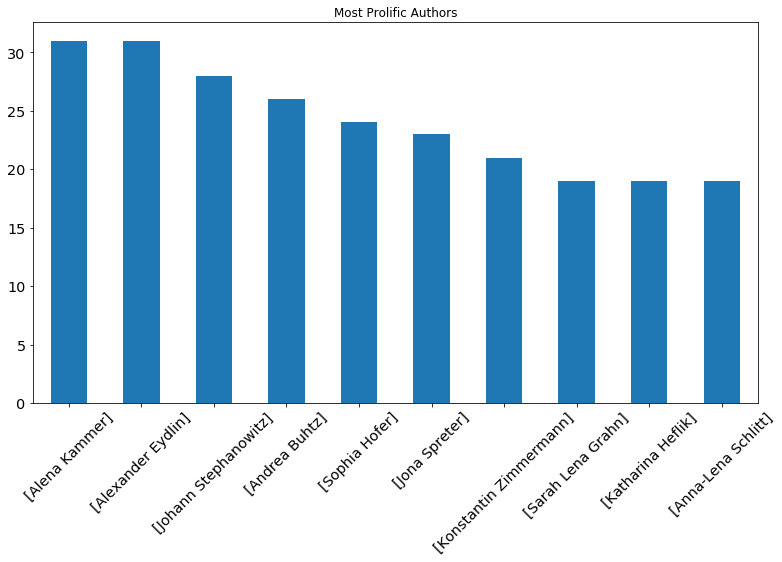

In [49]:
zeit_online["authors"].value_counts().sort_values(ascending = False).head(10).plot.bar(figsize=(13,7),
                                                                                      rot=45,
                                                                                      fontsize="x-large",
                                                                                      title= "Most Prolific Authors")

## Most Common Themes

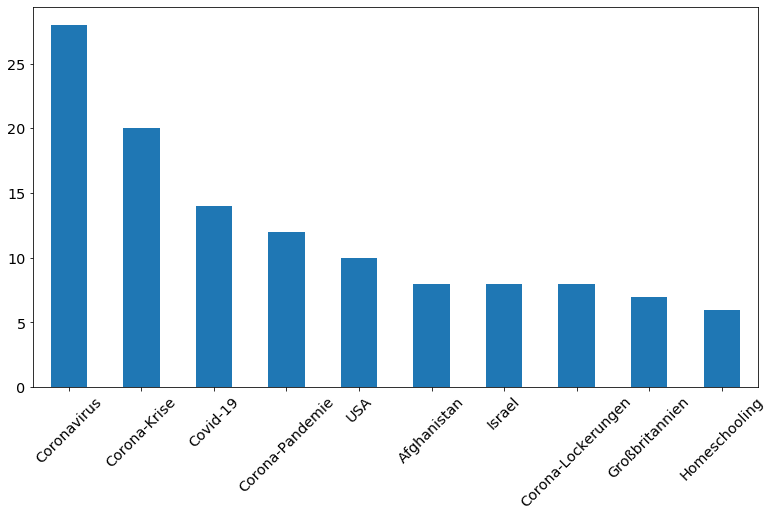

In [45]:
zeit_online["supertitle"].value_counts().sort_values(ascending = False).head(10).plot.bar(figsize=(13,7),
                                                          rot = 45,
                                                          fontsize="x-large")

## Release Hour of Most Commented Articles

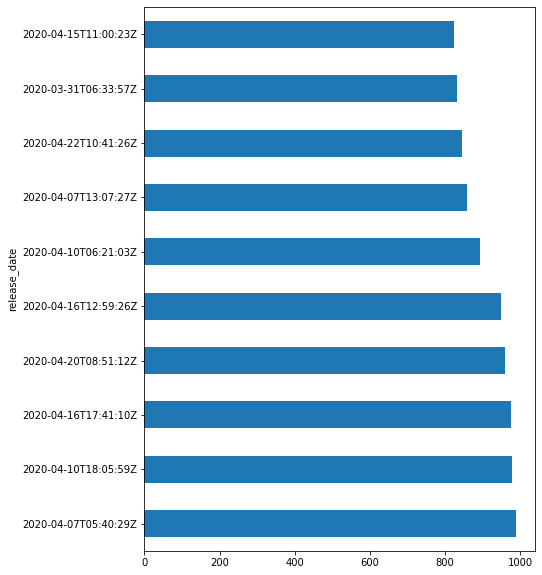

In [46]:
zeit_online.sort_values(by="n_comments", ascending = False).head(10).plot.barh(x="release_date",y="n_comments",
                                                                              figsize = (7,10), legend = False)

# Conclusion

In this project, we gathered Data from different endpoints of the API of the german newspaper DIE ZEIT and complemented it with the number of comments via webscrapping. After this, we joined all the data and cleaned it to make initial analysis possible.

Since analyzing the data does not belong to the project's goal, the analysis here is very superficial. Moreover, further data cleaning might be necessary depending on the purpose, to which the data is going to be used. However, the interesting task of data wrangling and cleaning is now complete.